## A classification model using SVM for Salary Data
In this notebook, we will built a classification model using Support Vector Machines (SVM) to predict whether an individual's salary is above or below $50,000 based on various features such as age, occupation, and more. We will perform exploratory data analysis to gain insights into the data and preprocess it for modeling. Next, we will train an SVM model using the training data. We'll evaluate the model's performance on the testing data, fine-tune its hyperparameters and perform additional preprocessing to improve its accuracy. Overall, the goal of this notebook is to demonstrate how to build a classification model using SVM and how to optimize its performance. 

## Section 1. Importing Necessary Libraries

In [50]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Section 2. Load Train and Test Dataset

In [51]:
# TODO: Load the 'SalaryData_Train.csv' file into a pandas dataframe called train_data 
train_data = pd.read_csv('SalaryData_Train.csv')
# TODO: Load the 'SalaryData_Test.csv' file into a pandas dataframe called test_data 
test_data = pd.read_csv('SalaryData_Test.csv')
# TODO: Display the first 5 or 10 rows of the train_data dataframe
train_data.loc[0:10]

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Section 3. EDA

In [52]:
# TODO: Print the shape of the train_data dataframe
print('train_data shape : ',train_data.shape)

# TODO: Print the shape of the test_data dataframe
print('test_data shape : ',test_data.shape)
# TODO: Print the information about the train_data dataframe  
print('train_data information : ')
train_data.info()
# TODO Display the summary statistics of the train_data dataframe  
print('train_data describe : ')
print(train_data.describe())
# TODO: Replace any NaN values in the train_data dataframe with 0 
train_data.fillna(0,inplace=True)
# TODO: Print the number of NaN values in each column of the train_data dataframe
print('number of nan value in each column :')
print(train_data.isna().sum())

train_data shape :  (30161, 14)
test_data shape :  (15060, 14)
train_data information : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30161 entries, 0 to 30160
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            30161 non-null  int64 
 1   workclass      30161 non-null  object
 2   education      30161 non-null  object
 3   educationno    30161 non-null  int64 
 4   maritalstatus  30161 non-null  object
 5   occupation     30161 non-null  object
 6   relationship   30161 non-null  object
 7   race           30161 non-null  object
 8   sex            30161 non-null  object
 9   capitalgain    30161 non-null  int64 
 10  capitalloss    30161 non-null  int64 
 11  hoursperweek   30161 non-null  int64 
 12  native         30161 non-null  object
 13  Salary         30161 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.2+ MB
train_data describe : 
                age   educationno   capit

## Data Visualization

                   age  educationno  capitalgain  capitalloss  hoursperweek
age           1.000000     0.043525     0.080152     0.060278      0.101598
educationno   0.043525     1.000000     0.124416     0.079691      0.152522
capitalgain   0.080152     0.124416     1.000000    -0.032218      0.080431
capitalloss   0.060278     0.079691    -0.032218     1.000000      0.052454
hoursperweek  0.101598     0.152522     0.080431     0.052454      1.000000


<AxesSubplot: >

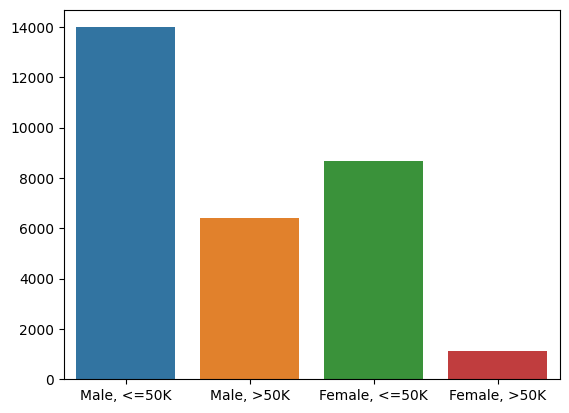

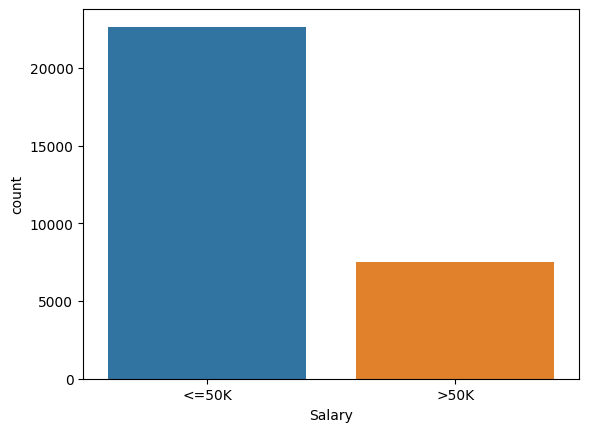

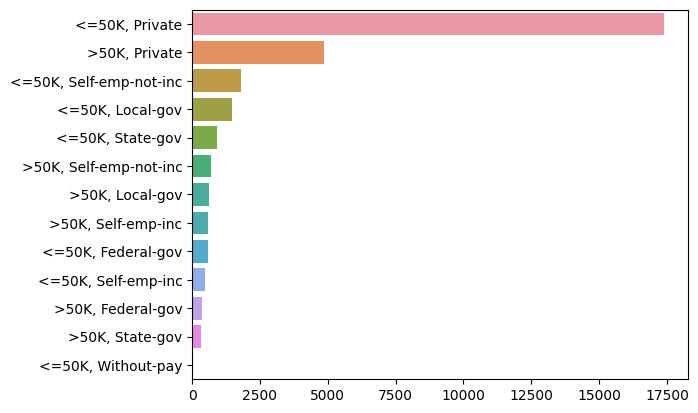

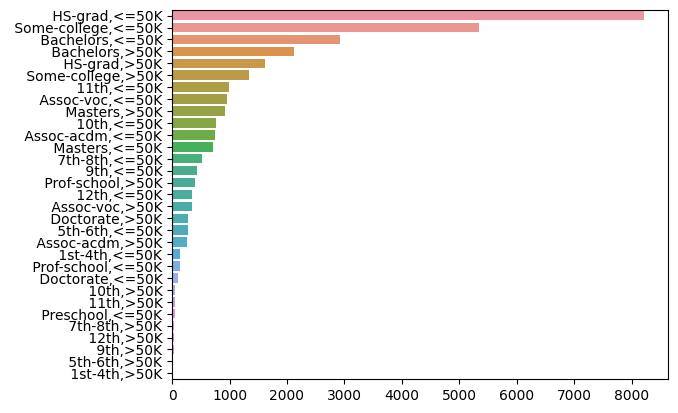

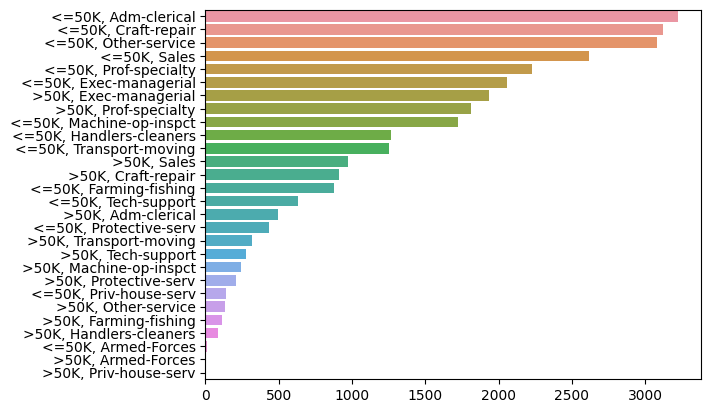

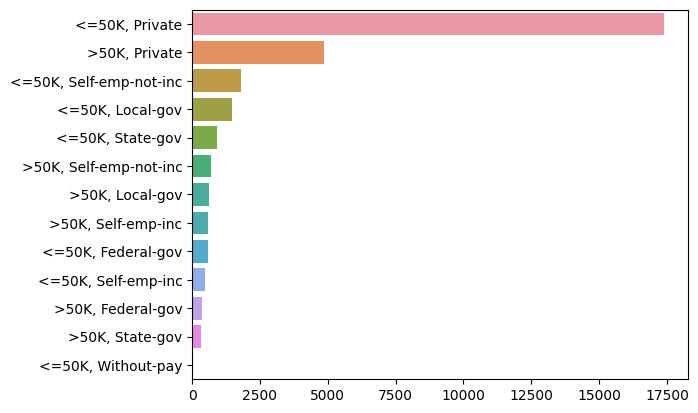

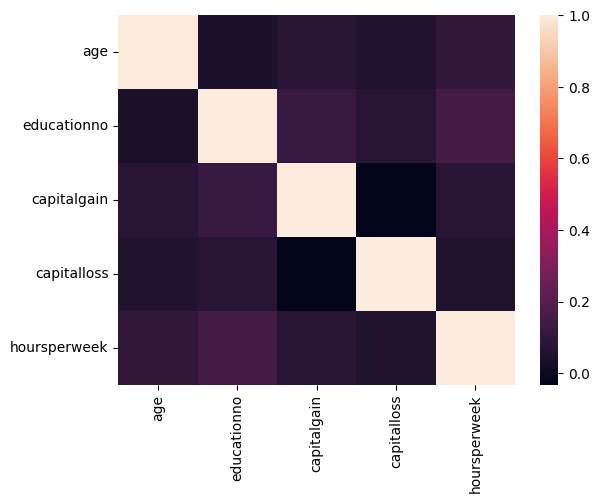

In [53]:
# TODO: Display pairwise relationships between variables in the train_data dataframe
train_data_corr = train_data.corr('pearson')
print(train_data_corr)
# TODO: Plot the average count of males and females in each salary group using a bar plot
train_data[['sex','Salary']] = train_data[['sex','Salary']].apply(lambda x : x.str.strip())
test_data[['sex','Salary']] = train_data[['sex','Salary']].apply(lambda x : x.str.strip())
count1 = len(train_data.loc[(train_data['sex']=='Male') & (train_data['Salary']=='<=50K')].index)
count2 = len(train_data.loc[(train_data['sex']=='Male') & (train_data['Salary']=='>50K')].index)
count3 = len(train_data.loc[(train_data['sex']=='Female') & (train_data['Salary']=='<=50K')].index)
count4= len(train_data.loc[(train_data['sex']=='Female') & (train_data['Salary']=='>50K')].index)
plt.figure()
sns.barplot(x=['Male, <=50K','Male, >50K','Female, <=50K','Female, >50K'],y=[count1,count2,count3,count4])

# TODO: Plot the count of each salary group in the train_data dataframe using a countplot
plt.figure()
sns.countplot(x = train_data["Salary"])

# TODO: Plot the count of each salary group in each workclass using a bar plot
workclass_salary = (train_data['Salary'] + ',' + train_data['workclass']).value_counts()
plt.figure()
sns.barplot(x=workclass_salary.values, y=workclass_salary.index)

# TODO: Plot the average count of each education level in each salary group using a bar plot
salary_education = (train_data['education'] + ',' + train_data['Salary']).value_counts()
plt.figure()
sns.barplot(x=salary_education.values, y=salary_education.index)
# TODO: Plot the average count of each occupation in each salary group using a bar plot
occupation_salary = (train_data['Salary'] + ',' + train_data['occupation']).value_counts()
plt.figure()
sns.barplot(x=occupation_salary.values, y=occupation_salary.index)
# TODO: Plot the average count of each workclass in each salary group using a bar plot
workclass_salary = (train_data['Salary'] + ',' + train_data['workclass']).value_counts()
plt.figure()
sns.barplot(x=workclass_salary.values, y=workclass_salary.index)
# TODO: Plot the correlation between variables in the train_data dataframe using a heatmap
plt.figure()
sns.heatmap(train_data_corr)

###  Outliers Detection

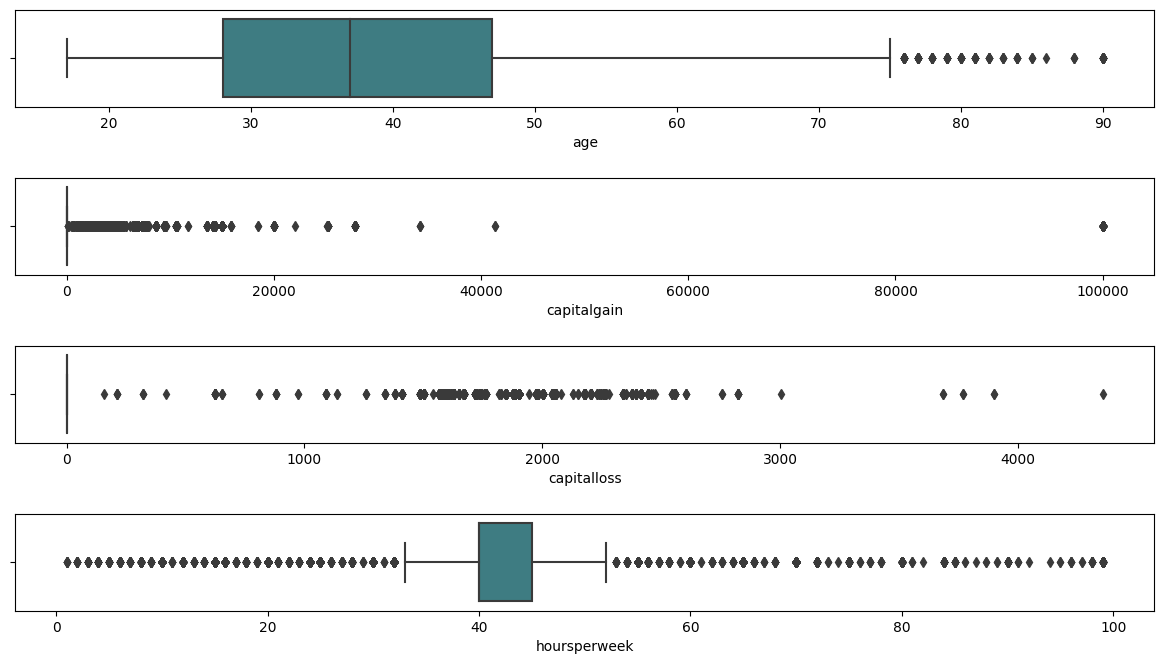

In [54]:
outlier1 = train_data.copy() 
fig, axes=plt.subplots(4,1,figsize=(12,7),sharex=False,sharey=False)
sns.boxplot(x='age',data=outlier1,palette='crest',ax=axes[0])
sns.boxplot(x='capitalgain',data=outlier1,palette='crest',ax=axes[1])
sns.boxplot(x='capitalloss',data=outlier1,palette='crest',ax=axes[2])
sns.boxplot(x='hoursperweek',data=outlier1,palette='crest',ax=axes[3])
plt.tight_layout(pad=2.0)

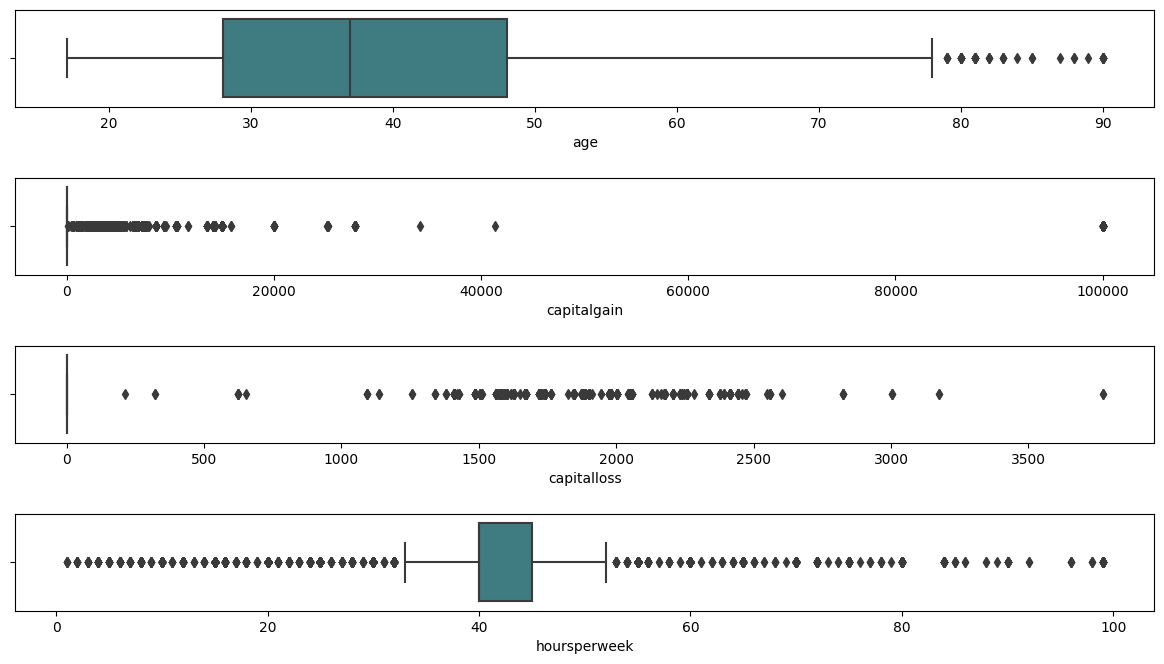

In [55]:
outlier2 = test_data.copy() 
fig, axes=plt.subplots(4,1,figsize=(12,7),sharex=False,sharey=False)
sns.boxplot(x='age',data=outlier2,palette='crest',ax=axes[0])
sns.boxplot(x='capitalgain',data=outlier2,palette='crest',ax=axes[1])
sns.boxplot(x='capitalloss',data=outlier2,palette='crest',ax=axes[2])
sns.boxplot(x='hoursperweek',data=outlier2,palette='crest',ax=axes[3])
plt.tight_layout(pad=2.0)

#### There are lot of outliers present in the dataframe but we can't drop them because they are present in a very large quantity and can be important for model building

## Section 4. Data Preprocessing

In [56]:
# TODO: Create a LabelEncoder object
le = LabelEncoder()
# TODO: Use the LabelEncoder object to transform these columns of the Train_data dataframe:
Train_data = train_data[['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'native','Salary']]

workclass_tr = le.fit_transform(Train_data['workclass'])
education_tr = le.fit_transform(Train_data['education'])
maritalstatus_tr = le.fit_transform(Train_data['maritalstatus'])
occupation_tr = le.fit_transform(Train_data['occupation'])
relationship_tr = le.fit_transform(Train_data['relationship'])
race_tr = le.fit_transform(Train_data['race'])
sex_tr = le.fit_transform(Train_data['sex'])
native_tr = le.fit_transform(Train_data['native'])

Train_data['workclass'] = workclass_tr
Train_data['education'] = education_tr
Train_data['maritalstatus'] = maritalstatus_tr
Train_data['occupation'] = occupation_tr
Train_data['relationship'] = relationship_tr
Train_data['race'] = race_tr
Train_data['sex'] = sex_tr
Train_data['native'] = native_tr
# workclass, education, maritalstatus, occupation, relationship, race, sex, native
# TODO: Display the modified Train_data dataframe
print(Train_data)
# TODO: Use a list comprehension to replace the values in the 'Salary' column of
# the Train_data dataframe with 0 if the value is<=50K' and 1 if the value is '>50K'
Train_data['Salary'] = [0 if sal == '<=50K' else 1 for sal in Train_data['Salary']]
print(Train_data)
# TODO: Do the same preprocessing to test data
Test_data = test_data[['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'native','Salary']]

workclass_ts = le.fit_transform(Test_data['workclass'])
education_ts = le.fit_transform(Test_data['education'])
maritalstatus_ts = le.fit_transform(Test_data['maritalstatus'])
occupation_ts = le.fit_transform(Test_data['occupation'])
relationship_ts = le.fit_transform(Test_data['relationship'])
race_ts = le.fit_transform(Test_data['race'])
sex_ts = le.fit_transform(Test_data['sex'])
native_ts = le.fit_transform(Test_data['native'])

Test_data['workclass'] = workclass_ts
Test_data['education'] = education_ts
Test_data['maritalstatus'] = maritalstatus_ts
Test_data['occupation'] = occupation_ts
Test_data['relationship'] = relationship_ts
Test_data['race'] = race_ts
Test_data['sex'] = sex_ts
Test_data['native'] = native_ts

Test_data['Salary'] = [0 if sal == '<=50K' else 1 for sal in Test_data['Salary']]
print(Test_data)

       workclass  education  maritalstatus  occupation  relationship  race  \
0              5          9              4           0             1     4   
1              4          9              2           3             0     4   
2              2         11              0           5             1     4   
3              2          1              2           5             0     2   
4              2          9              2           9             5     2   
...          ...        ...            ...         ...           ...   ...   
30156          2          7              2          12             5     4   
30157          2         11              2           6             0     4   
30158          2         11              6           0             4     4   
30159          2         11              4           0             3     4   
30160          3         11              2           3             5     4   

       sex  native Salary  
0        1      37  <=50K  
1      

## Section 5. Model Building

In [57]:
# TODO: Create X_train by dropping the 'Salary' column from the train_data dataframe
X_train = Train_data.drop(columns=['Salary'])
# TODO: Create y_train by selecting only the 'Salary' column from the train_data dataframe
y_train = Train_data['Salary']
# TODO: Create X_test by dropping the 'Salary' column from the test_data dataframe
X_test = Test_data.drop(columns=['Salary'])
# TODO: Create y_test by selecting only the 'Salary' column from the test_data dataframe
y_test = Test_data['Salary']
# TODO: Print the shape of X_train, y_train, X_test, and y_test dataframes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# TODO: Create a Support Vector Classifier object
svc = SVC()

(30161, 8)
(30161,)
(15060, 8)
(15060,)


## Section 6. Model Training | Testing | Evaluation - SVM Model

In [58]:
# TODO: Train the svc model with X_train and y_train 
svc.fit(X_train,y_train)
# TODO: Use the svc model to predict the values of y for X_test and store the result in y_pred
y_pred = svc.predict(X_test)
# TODO: Print the confusion matrix of y_test and y_pred
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix :')
print(cm)
# TODO: Print the classification report of y_test and y_pred
cr = classification_report(y_test,y_pred)
print('classification report :')
print(cr)
# TODO: Print the training accuracy of the svc model with X_train and y_train 
train_accuracy = accuracy_score(y_train,svc.predict(X_train))
print("train accuracy: ",train_accuracy)
# TODO: Print the testing accuracy of the svc model with X_test and y_test 
test_accuracy = accuracy_score(y_test,y_pred)
print("test accuracy: ",test_accuracy)

confusion matrix :
[[11340     0]
 [ 3720     0]]
classification report :
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     11340
           1       0.00      0.00      0.00      3720

    accuracy                           0.75     15060
   macro avg       0.38      0.50      0.43     15060
weighted avg       0.57      0.75      0.65     15060

train accuracy:  0.7510692616292564
test accuracy:  0.7529880478087649


## Section 7. Handling Imbalance Data

In [59]:
# TODO: Print the count of each unique value in the 'Salary' column of the train_data dataframe
print(train_data['Salary'].value_counts())
# TODO: Create a SMOTE object
smt = SMOTE()
# TODO: Use  the SMOTE object to resample the X_train and y_train dataframes
# and store the result in X_resampled and y_resampled, respectively
X_resampled, y_resampled = smt.fit_resample(X_train,y_train)
# TODO: Display the resampled X_resampled dataframe
print(X_resampled)
# TODO: Display the resampled y_resampled dataframe
print(y_resampled)
# TODO: Print the count of each unique value in the resampled y_resampled dataframe
print(y_resampled.value_counts())

<=50K    22653
>50K      7508
Name: Salary, dtype: int64
       workclass  education  maritalstatus  occupation  relationship  race  \
0              5          9              4           0             1     4   
1              4          9              2           3             0     4   
2              2         11              0           5             1     4   
3              2          1              2           5             0     2   
4              2          9              2           9             5     2   
...          ...        ...            ...         ...           ...   ...   
45301          2          9              2           3             0     4   
45302          2         11              2           2             0     4   
45303          2          9              2          13             0     4   
45304          4          9              2           3             0     4   
45305          2         12              2           3             0     4   

      

* 0.0001 < gamma < 10
* 0.1 < C < 100 -- gamma--decision boundary shape (Larger gamma value-overfitting of the model)
* C parameter adds a penalty for each misclassified data point

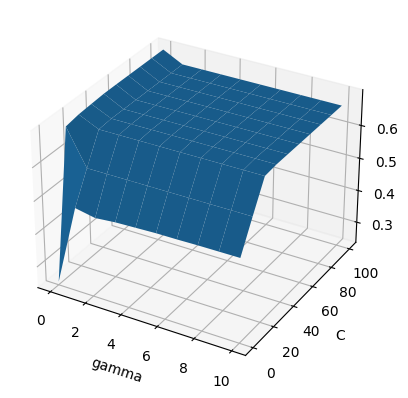

confusion matrix :
[[9349 1991]
 [2856  864]]
classification report :
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     11340
           1       0.30      0.23      0.26      3720

    accuracy                           0.68     15060
   macro avg       0.53      0.53      0.53     15060
weighted avg       0.65      0.68      0.66     15060

train accuracy:  0.7914193826464639
test accuracy:  0.6781540504648075


In [60]:
# TODO: Create a Support Vector Classifier object,
# try to change it's parameters for better accuracy
def cross_validate(X_resampled, y_resampled, X_test, y_test):
    idxs = np.random.randint(0,len(X_resampled),5000)
    idxs_t = np.random.randint(0,len(X_test),5000)
    x = X_resampled.loc[idxs]
    y = y_resampled.loc[idxs]
    x_t = X_test.loc[idxs_t]
    y_t = y_test.loc[idxs_t]
    gammas = np.linspace(0.0001,10,10)
    C = np.linspace(0.1,100,10)
    scores = np.zeros(shape=(len(gammas),len(C)))
    for i, gamma in enumerate(gammas):
        for j, c in enumerate(C):
            svc = SVC(C=c, gamma=gamma)
            svc.fit(x,y)
            y_pred = svc.predict(x_t)
            scores[i,j] = accuracy_score(y_t,y_pred)
    temp = np.argmax(scores)
    c_max = C[temp % len(gammas)]
    gamma_max = gammas[int(temp/len(gammas))]
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X,Y = np.meshgrid(gammas,C)
    ax.plot_surface(X,Y,scores)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()
    return gamma_max, c_max

gamma, c = cross_validate(X_resampled,y_resampled,X_test,y_test)
svc = SVC(gamma=gamma,C=c) 
# TODO: Train the model with resampled X and y dataframes as arguments
svc.fit(X_resampled,y_resampled)
# TODO: Use the model to predict the values of y for X_test and store the result in y_pred
y_pred = svc.predict(X_test)
# TODO: Print the confusion matrix of y_test and y_pred
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix :')
print(cm)
# TODO: Print the classification report of y_test and y_pred
cr = classification_report(y_test,y_pred)
print('classification report :')
print(cr)
# TODO: Print the training accuracy of the model with resampled X and y dataframes as arguments
train_accuracy = accuracy_score(y_train,svc.predict(X_train))
print("train accuracy: ",train_accuracy)
# TODO: Print the testing accuracy of the model with X_test and y_test as arguments
test_accuracy = accuracy_score(y_test,y_pred)
print("test accuracy: ",test_accuracy)

## Section 8. Feature Selection

In [61]:
def select_features(X_train, y_train, X_test):
    # TODO: Create a SelectKBest object with chi2 as the score function
    sk = SelectKBest(score_func=chi2,k='all')
    # TODO: Fit the X_train and y_train dataframes using the SelectKBest object
    sk.fit(X_train,y_train)
    # TODO: Transform the X_train dataframe using the SelectKBest object and store the result in X_train_fs
    X_train_fs = sk.transform(X_train)
    # TODO: Transform the X_test dataframe using the SelectKBest object and store the result in X_test_fs
    X_test_fs = sk.transform(X_test)
    # TODO: Return the X_train_fs, X_test_fs, and SelectKBest object
    return X_train_fs, X_test_fs, sk

[   4.06126126  264.81580716  982.22765927  218.59737751 3435.38273075
   29.33953542  459.21929758   16.70731997]


<AxesSubplot: >

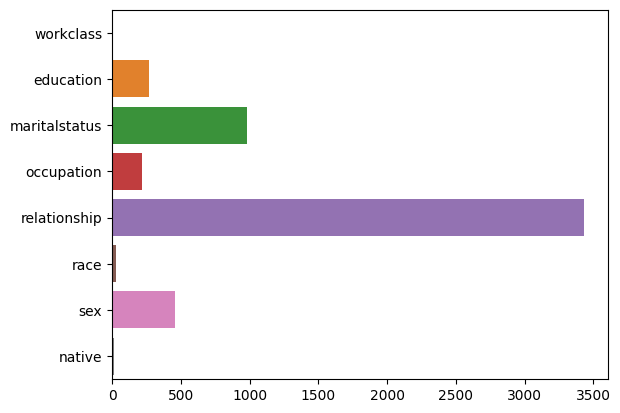

In [62]:
# TODO: Call the select_features() function and store the result in X_fs, X_test_fs, and fs
X_train_fs, X_test_fs, sk = select_features(X_train,y_train,X_test)
# TODO: print the corresponding score of each feature using scores_ attribute of the fs object
scores = sk.scores_
print(scores)
# TODO: Create a bar plot of the scores
# TODO: Display the bar plot 
sns.barplot(x=scores,y=X_train.columns)
# TODO Pick out the most relevant features
# the most relevant features are relationship, martialstatus, sex, education, occupation

In [63]:
# TODO: Create a copy of the train_data dataframe called train_data_copy 
train_data_copy = Train_data.copy(True)
# TODO: Drop the columns with irrelevant features from the train_data_copy dataframe 
train_data_copy.drop(columns=['workclass','race','native'],inplace=True)
# TODO: Display the train_data_copy dataframe
print(train_data_copy)
# TODO: Do the same to the test_data
test_data_copy = Test_data.copy(True)
test_data_copy.drop(columns=['workclass','race','native'],inplace=True)
print(test_data_copy)

       education  maritalstatus  occupation  relationship  sex  Salary
0              9              4           0             1    1       0
1              9              2           3             0    1       0
2             11              0           5             1    1       0
3              1              2           5             0    1       0
4              9              2           9             5    0       0
...          ...            ...         ...           ...  ...     ...
30156          7              2          12             5    0       0
30157         11              2           6             0    1       1
30158         11              6           0             4    0       0
30159         11              4           0             3    1       0
30160         11              2           3             5    0       1

[30161 rows x 6 columns]
       education  maritalstatus  occupation  relationship  sex  Salary
0              1              4           6        

## Section 9. Model Training with Highly Relevant Features


In [64]:
# TODO: Repeat all the steps in Section 6 with the new dataset that has irrelevant features removed
svc = SVC()
X_train = train_data_copy.drop(columns=['Salary'])
X_test = test_data_copy.drop(columns=['Salary'])
y_train = train_data_copy['Salary']
y_test = test_data_copy['Salary']
svc.fit(X_train,y_train)
# TODO: Use the svc model to predict the values of y for X_test and store the result in y_pred
y_pred = svc.predict(X_test)
# TODO: Print the confusion matrix of y_test and y_pred
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix :')
print(cm)
# TODO: Print the classification report of y_test and y_pred
cr = classification_report(y_test,y_pred)
print('classification report :')
print(cr)
# TODO: Print the training accuracy of the svc model with X_train and y_train 
train_accuracy = accuracy_score(y_train,svc.predict(X_train))
print("train accuracy: ",train_accuracy)
# TODO: Print the testing accuracy of the svc model with X_test and y_test 
test_accuracy = accuracy_score(y_test,y_pred)
print("test accuracy: ",test_accuracy)

confusion matrix :
[[10471   869]
 [ 3347   373]]
classification report :
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     11340
           1       0.30      0.10      0.15      3720

    accuracy                           0.72     15060
   macro avg       0.53      0.51      0.49     15060
weighted avg       0.64      0.72      0.66     15060

train accuracy:  0.7786213984947449
test accuracy:  0.7200531208499336
